# Homework 9 (DL Monday, December 4 at 12:00 PM)
#### ELEC-E8740 - Basics of sensor fusion - Autumn 2023

In [12]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

#### Consider the following 1D non-linear model
$$
x_k = x_{k-1} - 0.01sin(x_{k-1}) + q_{k-1}\\
y_k = 0.5sin(2x_k)+ r_k
$$
where $q_{k-1}$ has variance of $0.01^2$ and $r_k$ has variance of $0.02^2$.

### Part a (1 point): Simulate 100 steps of states and measurements from the model. Plot the data.

In [13]:
def model_simulation(seed_number, steps):
    """ 
    1D non-linear model simulation
    -------
    Input:
        seed_number: it is used to generate the same sequence of random numbers
        steps: number of steps
    Output:
        xs: state trajectory
        ys: measurement tajectory
        
    """
    np.random.seed(seed_number)      # do not change this line
    xs = np.zeros((steps, 1))        # do not change this line
    ys = np.zeros((steps, 1))        # do not change this line
    # To draw random samples from a normal (Gaussian) distribution, you could use np.random.normal function
    # Attention: the arguments of np.random.normal are mean and "Standard deviation"
    # YOUR CODE HERE
    for i in range(1, steps):
        q = np.random.normal(0, 0.01)
        r = np.random.normal(0, 0.02)
        xs[i] = xs[i-1] -0.01*np.sin(xs[i-1]) + q
        ys[i] = 0.5*np.sin(2*xs[i]) + r
    # raise NotImplementedError()
    return xs, ys # do not change this line

Feel free to uncomment and run the given code below.

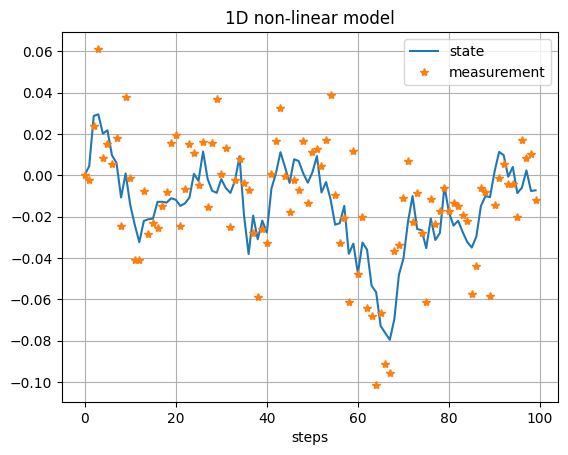

In [14]:
xs, ys = model_simulation(5, 100)
plt.plot(xs, label='state')
plt.plot(ys, '*', label='measurement')
plt.title('1D non-linear model')
plt.xlabel('steps')
plt.legend()
plt.grid();

In [15]:
def bootstrap_particle_filter(seed_number, steps, num_particles):
    # Model simulation to get measurements ys
    true_states, measurements = model_simulation(seed_number, steps)

    # Initialize particles randomly
    np.random.seed(seed_number)
    particles = np.random.uniform(-2 * np.pi, 2 * np.pi, size=(num_particles, 1))

    # Initialize weights uniformly
    weights = np.ones((num_particles,)) / num_particles

    # Perform bootstrap particle filtering
    estimated_states = []
    for t in range(steps):
        # Prediction: Move particles based on the nonlinear model
        for i in range(num_particles):
            q = np.random.normal(0, 0.01)
            particles[i] = particles[i] - 0.01 * np.sin(particles[i]) + q

        # Update step: Calculate weights based on the measurement likelihood
        for i in range(num_particles):
            r = np.random.normal(0, 0.02)
            particle_measurement = 0.5 * np.sin(2 * particles[i]) + r
            likelihood = 1.0 / np.sqrt(2 * np.pi * 0.02**2) * np.exp(-0.5 * ((measurements[t] - particle_measurement) / 0.02)**2)
            weights[i] *= likelihood

        # Normalize weights
        weights /= np.sum(weights)

        # Resampling step (Bootstrap)
        indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles = particles[indices]
        weights.fill(1.0 / num_particles)

        # Estimate current state (weighted average of particles)
        estimated_state = np.sum(particles * weights[:, np.newaxis])
        estimated_states.append(estimated_state)

    return true_states, measurements, np.array(estimated_states)


In [16]:
def run_bootstrap_particle_filter(seed_number, steps, num_particles):
    true_states, measurements, estimated_states = bootstrap_particle_filter(seed_number, steps, num_particles)

    # Compute RMSE
    rmse = compute_rmse(true_states, estimated_states)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(steps), true_states, label='True States', color='blue', alpha=0.7)
    plt.plot(range(steps), measurements, label='Measurements', color='green', alpha=0.7)
    plt.plot(range(steps), estimated_states, label='Estimated States', color='red', alpha=0.7)
    plt.title('Bootstrap Particle Filter')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse, np.mean(estimated_states)  # Return RMSE and mean of estimated states


/tmp/ipykernel_22549/325090563.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] *= likelihood


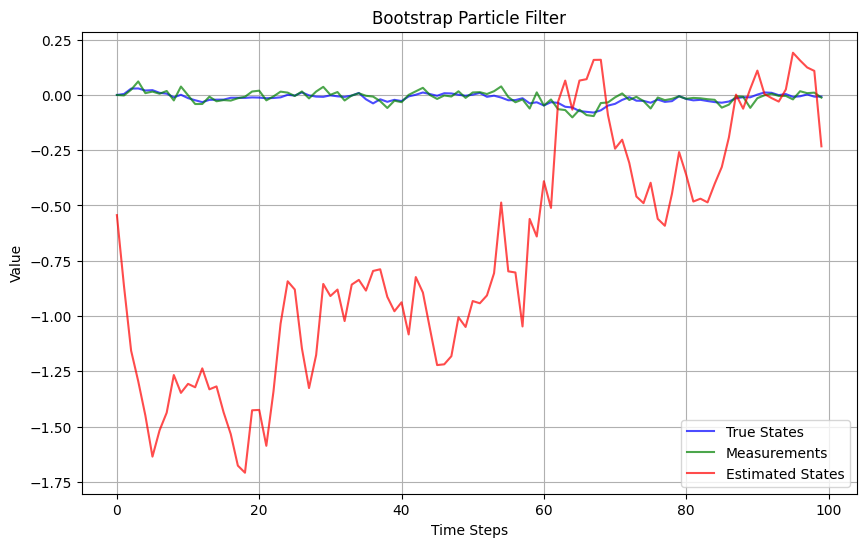

In [19]:
def compute_rmse(true_states, estimated_states):
    return np.sqrt(np.mean((true_states - estimated_states)**2))
rmse, estimated_mean = run_bootstrap_particle_filter(5, 100, 1000)

### Part b (1 point): Derive the necessary derivatives.

In [4]:
def derivatives_ssm(x):
    """ 
    Derivatives of dynamic functin and measurement function
    -------
    Input:
        x: state
    Output:
        Fx: value of derivative of the dynamic function tanh(.) at state x
        Gx: value of derivative of the measurement function sin(.) at state x
        
    """    
    # Fx = ?
    # Gx = ?
    # YOUR CODE HERE
    # raise NotImplementedError()
    Fx = 1 - np.tanh(x)**2
    Gx = np.cos(x)
    return Fx, Gx # do not change this line
    

In [5]:
assert np.allclose(derivatives_ssm(0), (1.0, 1.0), rtol=1e-03, atol=1e-04)
assert np.allclose(derivatives_ssm(-np.pi/2), (0.159, 0.0), rtol=1e-03, atol=1e-04)


### Part b (1 point): and check that they are correct by using numerical finite differences.
To approximately find the derivative a function $f(.)$ using finite difference method, you could select a small step size $h$ and compute $\frac{f(x + h) - f(x)}{h}$. In this part, use this method to find the derivatives of the dynamic function $tanh(.)$ and measurement function $sin()$.

In [6]:
def derivatives_numerically(x, h):
    """ 
    Derivatives of dynamic functin and measurement function by using numerical finite differences 
    -------
    Input:
        x: state
        h: step size
    Output:
        Fx_n: value of numerical derivative of the dynamic function tanh(.) at state x
        Gx_n: value of numerical derivative of the measurement function sin(.) at state x
        
    """
    # YOUR CODE HERE
    Fx_n = (np.tanh(x+h) - np.tanh(x))/(h)
    Gx_n = (np.sin(x+h) - np.sin(x))/(h)

    # raise NotImplementedError()
    return Fx_n, Gx_n # do not change this line

In [7]:
assert np.allclose(derivatives_numerically(0.0, 0.5), (0.924, 0.958), rtol=1e-03, atol=1e-04)
assert np.allclose(derivatives_numerically(0.0, 1e-6), (0.999, 0.999), rtol=1e-03, atol=1e-04)
assert np.allclose(derivatives_numerically(-np.pi/2, 1e-6), (0.159, 5e-7), rtol=1e-03, atol=1e-04)


### Part c (1 point): Implement and run EKF for the model. Plot the results.
#### Note: the input of the following "Extended_Kalman_Filter" function is only the measurements. Please do not change that and define any nesessary parameters inside the function.

#### The output should be Extended Kalman filter means and covariances of the whole trajectory.

In [10]:
def Extended_Kalman_Filter(Y):
    """ 
    Extended Kalman filter state estimation for 1D non-linear state space model
    
    -------
    Input:
        Y: measurements
    Output:
        mean_ekf: Extended Kalman filter mean estimation
        cov_ekf: Extended Kalman filter covariance estimation
        
    """
    steps = Y.shape[0]
    mean_ekf = np.zeros((steps, 1))      # do not change this line
    cov_ekf = np.zeros((steps, 1, 1))    # do not change this line
    # YOUR CODE HERE
    # raise NotImplementedError()
    m = 0.1
    T = Y.shape[0]
    Q = 0.1**2
    P0 = 0.1**2
    cov_ekf[0] = P0
    
    
    for i in range(steps):
        # prediction
        x_ = np.sin(Y[i])
        F_x, G_x = derivatives_ssm(Y[i])
        P_ = F_x*cov_ekf[i]*F_x.T + Q
         # update
        K_n = P_*G_x.T*(G_x*P_*G_x.T + m**2)**(-1)
        mean_ekf[i] = x_ + K_n*(Y[i] - np.sin(x_))
        cov_ekf[i] = P_ - K_n*(G_x*P_*G_x.T + m**2)*K_n.T
    
        

    
    return mean_ekf, cov_ekf # do not change this line
observations =  model_simulation(1, 100)[1]
x_ekf, cov_ekf = Extended_Kalman_Filter(observations)


Feel free to uncomment and run the given code below.

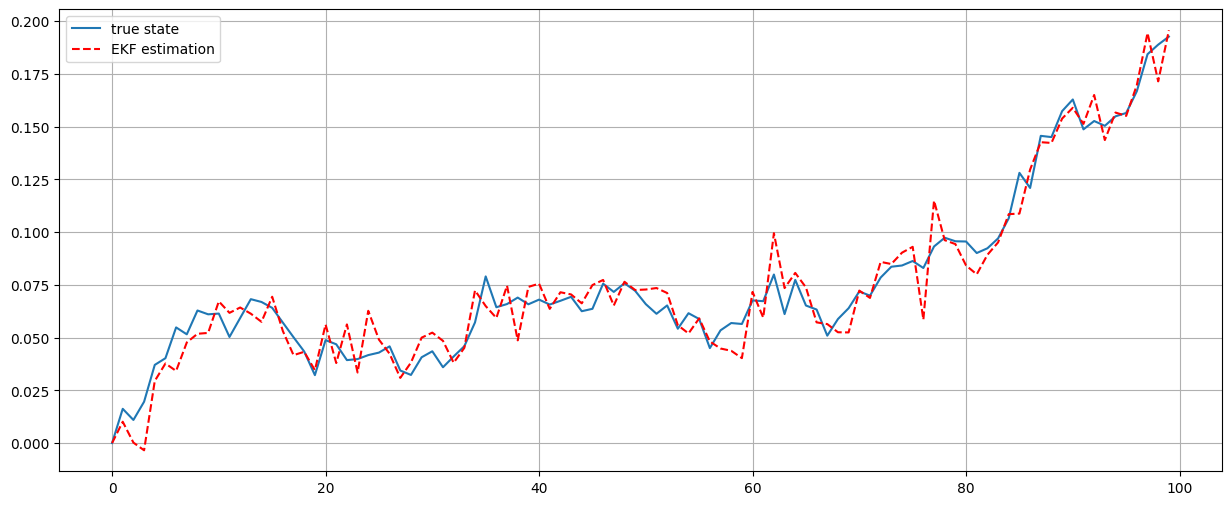

In [11]:
observations =  model_simulation(1, 100)[1]
x_ekf, cov_ekf = Extended_Kalman_Filter(observations)
plt.figure(figsize=(15,6))
plt.plot(model_simulation(1, 100)[0], label='true state')
plt.plot(x_ekf[:,0], 'r--', label='EKF estimation')
plt.legend()
plt.grid();